In [154]:
%matplotlib inline
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np
from PIL import Image

import tensorflow as tf
# tf.enable_eager_execution()
# import tensorflow.contrib.eager as tfe
import sys
import os
# from sklearn.utils import shuffle
# from cache import cache
# import pydot
# import graphviz
# from sklearn.model_selection import train_test_split
import time
import pickle
# from tqdm import tqdm
# import copy
# import re
from random import sample
import random
import requests

In [3]:
tf.__version__

'1.15.0'

In [4]:
tf.keras.__version__

'2.2.4-tf'

In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7814114441763272693
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16645223374866346008
physical_device_desc: "device: XLA_CPU device"
]


# Doanload Data

In [5]:
# os.path.abspath('.')

'/home/c_weiwei_cao/crow'

In [8]:
# annotation_zip = tf.keras.utils.get_file('annotations.zip',
#                                          cache_subdir=os.path.abspath('.')+'/data/',
#                                          origin = 'https://lilablobssc.blob.core.windows.net/caltechcameratraps/labels/caltech_images_20190919.json.zip',
#                                          extract = True)

9478144/9470683 [==============================] - 1s 0us/step


In [12]:
# image_zip = tf.keras.utils.get_file('images.zip',
#                                          cache_subdir=os.path.abspath('.')+'/data/',
#                                          origin = 'https://lilablobssc.blob.core.windows.net/caltechcameratraps/cct_images.tar.gz',
#                                          extract = True)

112540770304/112540764160 [==============================] - 9326s 0us/step


In [13]:
# annotation_zip

'/home/c_weiwei_cao/crow/data/annotations.zip'

In [14]:
# image_zip

'/home/c_weiwei_cao/crow/data/images.zip'

# Prepare Data for Modeling

In [6]:
# get data from json
with open("data/caltech_images_20190919.json", 'r') as f:
    annotations = json.load(f)

annot_df = pd.DataFrame.from_dict(annotations['annotations'])
image_df = pd.DataFrame.from_dict(annotations['images'])

# get animal name map 
category_id = []
category_name = []

for i in annotations['categories']:
    category_id.append(i['id'])
    category_name.append(i['name'])
    
category_dict = dict(zip(category_id, category_name))
annot_df['category_name'] = annot_df['category_id'].map(category_dict)

# drop duplicate annotations
annot_df.sort_values("image_id", inplace = True) 
annot_df_nodup = annot_df.drop_duplicates(subset ="image_id", keep = 'first')

# merge annotation and image data together
image_df.rename(columns={"id": "image_id"}, inplace=True)
image_df.sort_values("image_id", inplace = True) 
image_df_annot = pd.concat([image_df.set_index('image_id'), annot_df_nodup.set_index('image_id')], axis=1, join='inner').reset_index()

image_df_annot.head()

,image_id,seq_num_frames,date_captured,seq_id,height,width,location,rights_holder,file_name,frame_num,id,category_id,category_name
0,5858bf1e-23d2-11e8-a6a3-ec086b02610b,1,2014-07-10 14:20:20,6fc5ac4a-5567-11e8-b3db-dca9047ef277,1494,2048,96,Erin Boydston,test/5858bf1e-23d2-11e8-a6a3-ec086b02610b.jpg,1,52acca15-7d6d-11e7-884d-7845c41c2c67,30,empty
1,5858bf20-23d2-11e8-a6a3-ec086b02610b,1,2014-05-26 13:44:00,6fbb3c73-5567-11e8-b378-dca9047ef277,1494,2048,96,Erin Boydston,test/5858bf20-23d2-11e8-a6a3-ec086b02610b.jpg,1,f77c64a8-7d6e-11e7-884d-7845c41c2c67,30,empty
2,5858bf21-23d2-11e8-a6a3-ec086b02610b,1,2014-09-16 08:16:51,7006f717-5567-11e8-b4c6-dca9047ef277,1494,2048,114,Erin Boydston,test/5858bf21-23d2-11e8-a6a3-ec086b02610b.jpg,1,1aa83e59-7d71-11e7-884d-7845c41c2c67,10,rabbit
3,5858bf22-23d2-11e8-a6a3-ec086b02610b,1,2014-05-27 14:57:44,6fbd60e3-5567-11e8-a122-dca9047ef277,1494,2048,96,Erin Boydston,test/5858bf22-23d2-11e8-a6a3-ec086b02610b.jpg,1,45913ae8-7d6d-11e7-884d-7845c41c2c67,30,empty
4,5858bf23-23d2-11e8-a6a3-ec086b02610b,1,2014-06-06 12:31:06,6fbf5a47-5567-11e8-9655-dca9047ef277,1494,2048,96,Erin Boydston,test/5858bf23-23d2-11e8-a6a3-ec086b02610b.jpg,1,5f7e6e7a-7d6e-11e7-884d-7845c41c2c67,30,empty


# Show Image

In [9]:
def load_image(path, size=None):
    """
    Load the image from the given file-path and resize it
    to the given size if not None.
    """

    # Load the image using PIL.
    img = Image.open(path)

    # Resize image if desired.
    if not size is None:
        img = img.resize(size=size, resample=Image.LANCZOS)

    # Convert image to numpy array.
    img = np.array(img)

    # Scale image-pixels so they fall between 0.0 and 1.0
    img = img / 255.0

    # Convert 2-dim gray-scale array to 3-dim RGB array.
    if (len(img.shape) == 2):
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)

    return img

def show_image(path, category):
    """
    Load and plot an image from the training- or validation-set
    with the given index.
    """

    #path = filenames_train[idx]
    #caption = captions_train[idx]

    # Print the captions for this image.
    print("Category: " + category)
    
    # Load the image and plot it.
    img = load_image(path)
    plt.imshow(img)
    plt.show()
    
def show_image_by_category(images=1, category = 'any'):
    path = 'data/cct_images/'
    if category == 'any':
        samples = image_df_annot.sample(n=images)
    else:
        samples = image_df_annot[image_df_annot['category_name']==category].sample(n=images)
    for id, sample in samples.iterrows():
        image_id = sample['image_id']
        filename= 'data/cct_images/'+image_id + '.jpg'
        print(sample['category_name'] + " " + image_id)
        img = load_image(filename)
        plt.imshow(img)
        plt.show()    

deer 597fee58-23d2-11e8-a6a3-ec086b02610b


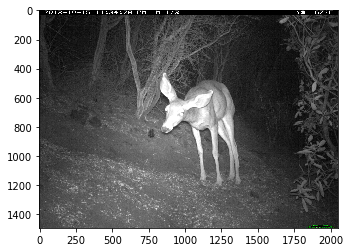

deer 5a26397b-23d2-11e8-a6a3-ec086b02610b


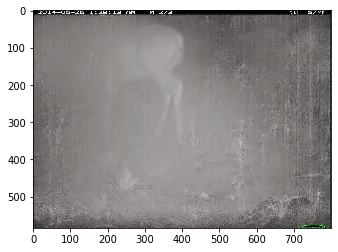

deer 5a0c9b9f-23d2-11e8-a6a3-ec086b02610b


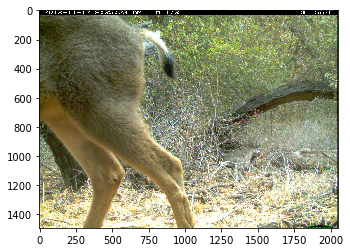

In [10]:
show_image_by_category(3, 'deer')

Category: coyote


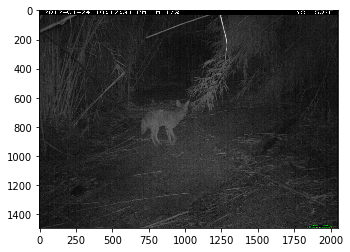

In [21]:
id = 102113
show_image(img_path_vector[id], cat_name_vector[id])

In [24]:
image_df_annot2 = image_df_annot.sort_values(["seq_id", "frame_num"])

In [25]:
image_df_annot2.head(20)

,image_id,seq_num_frames,date_captured,seq_id,height,width,location,rights_holder,file_name,frame_num,id,category_id,category_name
30581,58960811-23d2-11e8-a6a3-ec086b02610b,3,2011-05-31 13:59:06,6efd2387-5567-11e8-8fa6-dca9047ef277,1494,2048,75,Justin Brown,test/58960811-23d2-11e8-a6a3-ec086b02610b.jpg,1,212ad942-7d5b-11e7-884d-7845c41c2c67,30,empty
21503,5883e7c6-23d2-11e8-a6a3-ec086b02610b,3,2011-06-01 03:03:50,6efd254a-5567-11e8-a9e2-dca9047ef277,1494,2048,75,Justin Brown,test/5883e7c6-23d2-11e8-a6a3-ec086b02610b.jpg,1,212ad94f-7d5b-11e7-884d-7845c41c2c67,6,bobcat
103214,5922ebf9-23d2-11e8-a6a3-ec086b02610b,3,2011-06-01 03:03:52,6efd254a-5567-11e8-a9e2-dca9047ef277,1494,2048,75,Justin Brown,test/5922ebf9-23d2-11e8-a6a3-ec086b02610b.jpg,3,212ad959-7d5b-11e7-884d-7845c41c2c67,6,bobcat
82101,58fa5fba-23d2-11e8-a6a3-ec086b02610b,3,2011-06-01 03:03:58,6efd2611-5567-11e8-a6f8-dca9047ef277,1494,2048,75,Justin Brown,test/58fa5fba-23d2-11e8-a6a3-ec086b02610b.jpg,1,212ad955-7d5b-11e7-884d-7845c41c2c67,6,bobcat
123382,5948475f-23d2-11e8-a6a3-ec086b02610b,3,2011-06-01 03:03:59,6efd2611-5567-11e8-a6f8-dca9047ef277,1494,2048,75,Justin Brown,test/5948475f-23d2-11e8-a6a3-ec086b02610b.jpg,2,212ad927-7d5b-11e7-884d-7845c41c2c67,6,bobcat
14533,5874d676-23d2-11e8-a6a3-ec086b02610b,3,2011-06-01 03:04:00,6efd2611-5567-11e8-a6f8-dca9047ef277,1494,2048,75,Justin Brown,test/5874d676-23d2-11e8-a6a3-ec086b02610b.jpg,3,212ad92f-7d5b-11e7-884d-7845c41c2c67,6,bobcat
11595,586fdba6-23d2-11e8-a6a3-ec086b02610b,3,2011-06-02 15:21:09,6efd26a8-5567-11e8-94ff-dca9047ef277,1494,2048,75,Justin Brown,test/586fdba6-23d2-11e8-a6a3-ec086b02610b.jpg,1,212ad952-7d5b-11e7-884d-7845c41c2c67,6,bobcat
39660,58a8a111-23d2-11e8-a6a3-ec086b02610b,3,2011-06-02 15:21:10,6efd26a8-5567-11e8-94ff-dca9047ef277,1494,2048,75,Justin Brown,test/58a8a111-23d2-11e8-a6a3-ec086b02610b.jpg,2,212ad93e-7d5b-11e7-884d-7845c41c2c67,6,bobcat
42873,58af7531-23d2-11e8-a6a3-ec086b02610b,3,2011-06-02 15:21:11,6efd26a8-5567-11e8-94ff-dca9047ef277,1494,2048,75,Justin Brown,test/58af7531-23d2-11e8-a6a3-ec086b02610b.jpg,3,212ad95f-7d5b-11e7-884d-7845c41c2c67,6,bobcat
111794,59328d18-23d2-11e8-a6a3-ec086b02610b,3,2011-06-02 15:53:56,6efd2728-5567-11e8-86fb-dca9047ef277,1494,2048,75,Justin Brown,test/59328d18-23d2-11e8-a6a3-ec086b02610b.jpg,1,212ad92c-7d5b-11e7-884d-7845c41c2c67,6,bobcat


Category: opossum


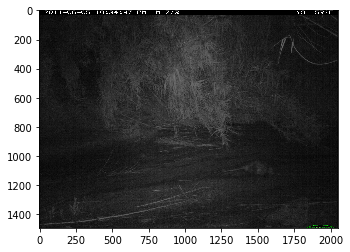

In [64]:
id = 20004
show_image('data/cct_images/' + image_df_annot2.iloc[id]['image_id'] + '.jpg', \
           image_df_annot2.iloc[id]['category_name'])

In [29]:
'data/cct_images/' + image_df_annot2.iloc[3]['image_id'] + '.jpg'

'data/cct_images/58fa5fba-23d2-11e8-a6a3-ec086b02610b.jpg'

# Split Data

In [70]:
loc = image_df_annot['location'].unique()
loc.sort()

In [71]:
loc

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139])

In [116]:
loc2 = image_df_annot.groupby(['location', 'category_name']).image_id.count()

In [117]:
loc2.reset_index().sort_values(by=['location','category_name'])
loc3 = pd.DataFrame(loc2).reset_index()

In [211]:
loc3.head()

,location,category_name,image_id
0,0,badger,6
1,0,bird,10
2,0,bobcat,124
3,0,car,1066
4,0,coyote,304


In [118]:
loc_pivot = loc3.pivot(index='location', columns='category_name', values='image_id')

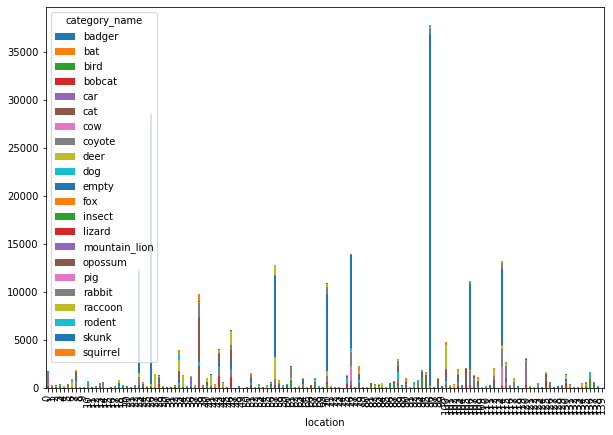

In [90]:
loc_pivot.plot.bar(stacked=True, figsize=(10,7))

In [146]:
url = 'https://lilablobssc.blob.core.windows.net/caltechcameratraps/CaltechCameraTrapsSplits_v0.json'
split = requests.get(url).json()
print(split)

{'info': {'version': '1.0', 'description': 'Train/val splits for Caltech Camera Traps'}, 'splits': {'train': ['10', '102', '103', '106', '107', '108', '108', '108', '109', '11', '110', '111', '112', '113', '115', '115', '115', '116', '117', '118', '119', '12', '120', '120', '120', '121', '122', '123', '124', '126', '127', '128', '129', '13', '131', '132', '133', '134', '135', '137', '138', '14', '15', '16', '17', '18', '2', '20', '21', '22', '23', '24', '25', '26', '29', '3', '31', '33', '33', '33', '35', '36', '38', '38', '38', '39', '4', '41', '43', '43', '43', '44', '47', '48', '49', '5', '50', '51', '51', '51', '52', '53', '55', '56', '57', '58', '59', '6', '61', '61', '61', '62', '64', '65', '66', '70', '71', '73', '75', '79', '80', '81', '82', '83', '86', '87', '88', '88', '88', '89', '90', '90', '90', '92', '93', '94', '96', '97', '98', '99'], 'val': ['0', '1', '100', '101', '104', '105', '114', '125', '130', '136', '139', '19', '27', '28', '30', '32', '34', '37', '40', '42', '4

In [147]:
train_val_loc = list(set(split['splits']['train']))

In [148]:
test_loc = list(set(split['splits']['val']))

In [207]:
random.seed(12)
val_loc = sample(train_val_loc, 40)

In [208]:
train_loc = [i for i in train_val_loc if i not in val_loc]

In [209]:
print(len(train_loc))
print(len(val_loc))
print(len(test_loc))

60
40
40


In [213]:
train_dist = loc3[loc3['location'].isin(train_loc)].groupby('category_name').image_id.sum().sort_values()
val_dist = loc3[loc3['location'].isin(val_loc)].groupby('category_name').image_id.sum().sort_values()
test_dist = loc3[loc3['location'].isin(test_loc)].groupby('category_name').image_id.sum().sort_values()

train_img = loc3[loc3['location'].isin(train_loc)].image_id.sum()
val_img = loc3[loc3['location'].isin(val_loc)].image_id.sum()
test_img = loc3[loc3['location'].isin(test_loc)].image_id.sum()

In [214]:
print('train: ' + str(train_img))
print('val: ' + str(val_img))
print('test: ' + str(test_img))

train: 120034
val: 60656
test: 62410


In [222]:
train_dist 
#/ train_img

category_name
pig                  2
insect               3
badger              10
cow                 42
lizard              85
mountain_lion      115
skunk              689
fox                756
dog               1239
rodent            2039
squirrel          2585
cat               2880
car               2981
bobcat            3006
bird              3159
raccoon           4105
rabbit            5822
deer              6005
opossum           8139
coyote            8290
empty            68082
Name: image_id, dtype: int64

In [223]:
val_dist 
#/ val_img

category_name
bat                  3
insect               3
badger              13
mountain_lion       15
lizard              53
car                150
squirrel           434
cat                584
skunk              613
rodent             941
fox               1121
bobcat            1275
raccoon           1283
dog               1642
opossum           1840
coyote            1896
deer              2206
bird              4161
rabbit            4652
empty            37771
Name: image_id, dtype: int64

In [224]:
test_dist 
#/ test_img

category_name
mountain_lion       15
badger              20
lizard             171
skunk              590
fox                697
rodent            1292
dog               1314
squirrel          1413
car               1586
cat               1703
rabbit            1871
bird              2201
cow               3584
bobcat            3671
deer              3980
raccoon           5593
coyote            6162
opossum           6655
empty            19892
Name: image_id, dtype: int64

### cap the empty class to the highest non-empty class?

In [228]:
classes = ['skunk','fox','rodent','dog','squirrel','cat','rabbit','bird','cow','bobcat','deer','raccoon','coyote','opossum']

In [226]:
image_df_annot.groupby('category_name').image_id.count().sort_values()

category_name
pig                   2
bat                   3
insect                6
badger               43
mountain_lion       145
lizard              309
skunk              1892
fox                2574
cow                3626
dog                4195
rodent             4272
squirrel           4432
car                4717
cat                5167
bobcat             7952
bird               9521
raccoon           10981
deer              12191
rabbit            12345
coyote            16348
opossum           16634
empty            125745
Name: image_id, dtype: int64

In [229]:
data_keep = image_df_annot[image_df_annot['category_name'].isin(classes)]

In [235]:
# sample 16000 other classes
data_other = image_df_annot[~image_df_annot['category_name'].isin(classes)].sample(n=16000)
data_other['category_name'] = 'other'
data_other['category_id'] = 30

In [238]:
# combine and shuffle
image_df_annot2 = pd.concat([data_keep, data_other]).reset_index().sample(frac=1)

In [239]:
image_df_annot2.groupby('category_name').image_id.count().sort_values()

category_name
skunk        1892
fox          2574
cow          3626
dog          4195
rodent       4272
squirrel     4432
cat          5167
bobcat       7952
bird         9521
raccoon     10981
deer        12191
rabbit      12345
other       16000
coyote      16348
opossum     16634
Name: image_id, dtype: int64

In [241]:
data_train = image_df_annot2[image_df_annot2['location'].isin(train_loc)]
data_val = image_df_annot2[image_df_annot2['location'].isin(val_loc)]
data_test = image_df_annot2[image_df_annot2['location'].isin(test_loc)]

In [243]:
print(data_train.shape)
print(data_val.shape)
print(data_test.shape)

(57404, 14)
(27403, 14)
(43323, 14)


In [244]:
# get image vector
img_vector_train = list('data/cct_images/' + data_train['image_id'] + '.jpg')
img_vector_val = list('data/cct_images/' + data_val['image_id'] + '.jpg')
img_vector_test = list('data/cct_images/' + data_test['image_id'] + '.jpg')

In [246]:
# get category vector
cat_name_vector_train = list(data_train['category_name'])
cat_id_vector_train = list(data_train['category_id'])

cat_name_vector_val = list(data_val['category_name'])
cat_id_vector_val = list(data_val['category_id'])

cat_name_vector_test = list(data_test['category_name'])
cat_id_vector_test = list(data_test['category_id'])